# Assignment 1 : 
- Fashion-MNIST Dataset으로 MLP를 자유롭게 구현해보세요.
- PyTorch, TensorFlow 선택 자유
- Data 파일을 따로 드리지 않습니다. Dataset과 관련된 모듈을 활용하여 직접 해보시길 바랍니다.
- 공개된 코드를 사용하셔도 좋습니다. 이 경우 출처를 밝혀 주시기 바랍니다.

# Import library

In [13]:
import time
import numpy as np
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 데이터 다운받기

torch.Size([60000, 28, 28])
torch.Size([60000])


Text(0.5, 1.0, '4')

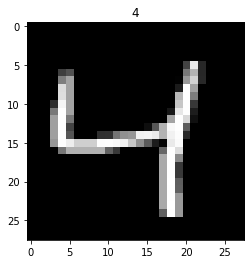

In [14]:
trainDataset = datasets.MNIST('../mnist_data/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(), # image to Tensor 기본으로 0과 1로 scailing 해준다.
#                                  transforms.Normalize((0.5, 0.5), (0.5, 0.5)) # image, label
                             ])) 

testDataset = datasets.MNIST("../mnist_data/", 
                             download=False,
                             train=False,
                             transform= transforms.Compose([
                               transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5), (0.5, 0.5))
                           ]))

# 데이터 확인
print(trainDataset.train_data.size())
print(trainDataset.train_labels.size())

idx=2
plt.imshow(trainDataset.train_data[idx,:,:].numpy(), cmap='gray')
plt.title('%i' % trainDataset.train_labels[idx])

In [15]:
# data loader
batch_size = 64
trainLoader = torch.utils.data.DataLoader(trainDataset,
                                         batch_size=batch_size,
                                         shuffle=True)

testLoader = torch.utils.data.DataLoader(testDataset,
                                         batch_size=batch_size,
                                         shuffle=True)

In [16]:
trainLoader.dataset.data[2]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,  67, 232,  39,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,  62,  81,   0,   

# Modeling

In [33]:
import torch.nn as nn
import torch.nn.functional as F

# nn은 레이어간 weight 공유, F는 단순히 연산만 
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__() # 상속받아 설계해야 한다.
        self.dense1 = nn.Linear(784, 512) # 첫번째 히든레이어 설정 (N, H1)
        self.dense1_bn = torch.nn.BatchNorm1d(512) # 첫번째 히든레이어 후 배치노멀라이제이션 적용
        self.dense2 = nn.Linear(512, 256) # 두번째 히든레이어 설정 (H1, H2)
        self.dense3 = nn.Linear(256, 256) # 세번째 히든레이어 설정 (H2, H3)
#         self.dense4 = nn.Linear(512, 10) # 마지막 레이어 (H3, O)
        self.dense4 = nn.Linear(256, 10) # 마지막 레이어 (H3, O)
    def forward(self, input):
        output = input.view(-1,784) # input값을 넣어 reshape 한다음 foward 과정
        output = self.dense1(output)
        output = self.dense1_bn(output)
        output = F.relu(output)
        output = self.dense2(output)
        output = self.dense3(output)
        output = F.dropout(output, training=self.training)
        output = self.dense4(output)
        return output

In [18]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 설정
# use gpu -> .cuda() : model과 Variable에 쓰임
model = Network().to(device)

# 손실함수 : nn.CrossEntropyLoss()의 경우 기본적으로 LogSoftmax()가 내장
criterion = nn.CrossEntropyLoss()

# 최적화 함수 : parameters를 통해 parameter 할당가능 ,lr : learning_rate
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

# Train

In [19]:
from torch.autograd import Variable

def train(epoch):

    model.train()
    train_loss = 0
    train_acc = 0

    for batch_idx, (data, label) in enumerate(trainLoader):
        data, label = Variable(data).to(device), Variable(label).to(device)
        output = model(data) #forward 단계 실행 => output계산
        loss = criterion(output, label) # 모델에서 나온 output과 label을 이용해 loss 계산

        optimizer.zero_grad() # 갱신할 Variable들에 대한 모든 변화도를 0으로 만듬
        loss.backward() # 역전파 단계 실행. 모델의 Variable들에 대한 loss의 변화도를 계산합니다.
        optimizer.step() # 가중치 갱신

        train_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1] # 텐서 배열의 최대값이 들어가있는 label반환
        train_acc += pred.eq(label.data.view_as(pred)).sum() # pred와 라벨 비교
        
        ### LOGGING
#         if not batch_idx % 50:
#             print ('Epoch: %03d | Batch %03d/%03d | Cost: %.4f' 
#                    %(epoch, batch_idx, 
#                      len(trainLoader), loss))
            
    train_loss /= len(trainLoader.dataset)

    print('Train Epoch: {} Average loss: {:.4f} Accuracy : {:.4f}%)'.format(epoch, train_loss, 100. * train_acc / len(trainLoader.dataset)))

# Test

In [20]:
def test():

    model.eval()
    test_loss = 0
    test_acc = 0

    for data, target in testLoader:
        # volatile=True no use backprob
        data, target = Variable(data, volatile=True).to(device), Variable(target).to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        test_acc += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(testLoader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {:.3f}%)'.format(test_loss, 100. * test_acc / len(testLoader.dataset)))

In [21]:
%%time
# 모델 초기화후 돌리기
model = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

for epoch in range(1, 11):
    train(epoch)
    test()
'''
1분30초 정도 걸리고
relu 적용 전 train데이터 정확도는 88, test의 경우는 85정도 나온다.
relu 적용 휴 train데이터 정확도는 98, test의 경우는 97정도 나온다.
'''

Train Epoch: 1 Average loss: 0.0060 Accuracy : 93.0000%)


/Users/daier/anaconda3/envs/testEnv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


Test set: Average loss: 0.0030, Accuracy: 94.000%)
Train Epoch: 2 Average loss: 0.0022 Accuracy : 96.0000%)
Test set: Average loss: 0.0023, Accuracy: 96.000%)
Train Epoch: 3 Average loss: 0.0018 Accuracy : 96.0000%)
Test set: Average loss: 0.0023, Accuracy: 96.000%)
Train Epoch: 4 Average loss: 0.0016 Accuracy : 97.0000%)
Test set: Average loss: 0.0028, Accuracy: 96.000%)
Train Epoch: 5 Average loss: 0.0014 Accuracy : 97.0000%)
Test set: Average loss: 0.0028, Accuracy: 96.000%)
Train Epoch: 6 Average loss: 0.0014 Accuracy : 97.0000%)
Test set: Average loss: 0.0029, Accuracy: 96.000%)
Train Epoch: 7 Average loss: 0.0013 Accuracy : 98.0000%)
Test set: Average loss: 0.0042, Accuracy: 96.000%)
Train Epoch: 8 Average loss: 0.0012 Accuracy : 98.0000%)
Test set: Average loss: 0.0034, Accuracy: 96.000%)
Train Epoch: 9 Average loss: 0.0011 Accuracy : 98.0000%)
Test set: Average loss: 0.0035, Accuracy: 97.000%)
Train Epoch: 10 Average loss: 0.0011 Accuracy : 98.0000%)
Test set: Average loss: 0.0

'\n따로 테스트 하는 경우에 넣지는 않았지만, relu 적용안한 것보다 relu적용한 것이 더 정확도가 높게 나온다.\n1분30초 정도 걸리고 train데이터 정확도는 98, test의 경우는 97정도 나온다.\n'

### 출처
### https://mjdeeplearning.tistory.com/81 (가장 기초부터 설명되어 있어서 따라해 보았다.)
### https://www.yceffort.kr/2019/01/27/pytorch-2-multi-perceptron(2)/

###  BATCHNORM 적용

In [23]:
%%time
model = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

for epoch in range(1, 11):
    train(epoch)
    test()
    
'''
1분 40초 정도 소요
첫번째 epoch부터 정확도 92 -> 94로 뛴것을 볼 수 있다.
train acc : 99, test acc : 98
'''

Train Epoch: 1 Average loss: 0.0034 Accuracy : 94.0000%)


/Users/daier/anaconda3/envs/testEnv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


Test set: Average loss: 0.0019, Accuracy: 96.000%)
Train Epoch: 2 Average loss: 0.0015 Accuracy : 97.0000%)
Test set: Average loss: 0.0015, Accuracy: 96.000%)
Train Epoch: 3 Average loss: 0.0011 Accuracy : 97.0000%)
Test set: Average loss: 0.0013, Accuracy: 97.000%)
Train Epoch: 4 Average loss: 0.0008 Accuracy : 98.0000%)
Test set: Average loss: 0.0011, Accuracy: 97.000%)
Train Epoch: 5 Average loss: 0.0007 Accuracy : 98.0000%)
Test set: Average loss: 0.0014, Accuracy: 97.000%)
Train Epoch: 6 Average loss: 0.0006 Accuracy : 98.0000%)
Test set: Average loss: 0.0015, Accuracy: 97.000%)
Train Epoch: 7 Average loss: 0.0006 Accuracy : 98.0000%)
Test set: Average loss: 0.0013, Accuracy: 98.000%)
Train Epoch: 8 Average loss: 0.0006 Accuracy : 98.0000%)
Test set: Average loss: 0.0016, Accuracy: 97.000%)
Train Epoch: 9 Average loss: 0.0005 Accuracy : 99.0000%)
Test set: Average loss: 0.0015, Accuracy: 97.000%)
Train Epoch: 10 Average loss: 0.0005 Accuracy : 99.0000%)
Test set: Average loss: 0.0

## 층을 2개 더 늘린 경우 (주석풀면서 실행해야함)

In [27]:
%%time
model = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

for epoch in range(1, 11):
    train(epoch)
    test()
'''
2분정도 소요되었고
히든레이어를 3층을 쌓아서 돌려 보았는데 확실히 시간이 더 걸린다.
train acc : 97 test acc : 97 
무조건 츠응ㄹ 많이 쌓는다고 좋은 거은 아닌 것 같다.
'''

Train Epoch: 1 Average loss: 0.0825 Accuracy : 86.0000%)


/Users/daier/anaconda3/envs/testEnv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


Test set: Average loss: 0.0112, Accuracy: 81.000%)
Train Epoch: 2 Average loss: 0.0039 Accuracy : 93.0000%)
Test set: Average loss: 0.0024, Accuracy: 96.000%)
Train Epoch: 3 Average loss: 0.0030 Accuracy : 95.0000%)
Test set: Average loss: 0.0025, Accuracy: 96.000%)
Train Epoch: 4 Average loss: 0.0026 Accuracy : 95.0000%)
Test set: Average loss: 0.0021, Accuracy: 96.000%)
Train Epoch: 5 Average loss: 0.0026 Accuracy : 96.0000%)
Test set: Average loss: 0.0025, Accuracy: 96.000%)
Train Epoch: 6 Average loss: 0.0022 Accuracy : 96.0000%)
Test set: Average loss: 0.0019, Accuracy: 97.000%)
Train Epoch: 7 Average loss: 0.0022 Accuracy : 96.0000%)
Test set: Average loss: 0.0022, Accuracy: 96.000%)
Train Epoch: 8 Average loss: 0.0023 Accuracy : 96.0000%)
Test set: Average loss: 0.0028, Accuracy: 96.000%)
Train Epoch: 9 Average loss: 0.0020 Accuracy : 97.0000%)
Test set: Average loss: 0.0029, Accuracy: 97.000%)
Train Epoch: 10 Average loss: 0.0021 Accuracy : 97.0000%)
Test set: Average loss: 0.0

## 층을 2개 쌓은것에 DROP OUT 적용

In [34]:
%%time
model = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

for epoch in range(1, 11):
    train(epoch)
    test()
'''
3분 정도 소요되었고 
dropout이 학습시간을 증가시켜 나온 결과이고
dropout이 일반화 성능을 증가시켜
test acc 95이 train 94더 높게 나옴을 볼 수 있다.
'''

Train Epoch: 1 Average loss: 0.1909 Accuracy : 88.0000%)


/Users/daier/anaconda3/envs/testEnv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


Test set: Average loss: 0.0056, Accuracy: 91.000%)
Train Epoch: 2 Average loss: 0.0065 Accuracy : 91.0000%)
Test set: Average loss: 0.0161, Accuracy: 84.000%)
Train Epoch: 3 Average loss: 0.0059 Accuracy : 92.0000%)
Test set: Average loss: 0.0047, Accuracy: 92.000%)
Train Epoch: 4 Average loss: 0.0053 Accuracy : 92.0000%)
Test set: Average loss: 0.0034, Accuracy: 95.000%)
Train Epoch: 5 Average loss: 0.0052 Accuracy : 93.0000%)
Test set: Average loss: 0.0035, Accuracy: 95.000%)
Train Epoch: 6 Average loss: 0.0049 Accuracy : 93.0000%)
Test set: Average loss: 0.0051, Accuracy: 93.000%)
Train Epoch: 7 Average loss: 0.0048 Accuracy : 93.0000%)
Test set: Average loss: 0.0052, Accuracy: 94.000%)
Train Epoch: 8 Average loss: 0.0048 Accuracy : 93.0000%)
Test set: Average loss: 0.0061, Accuracy: 92.000%)
Train Epoch: 9 Average loss: 0.0049 Accuracy : 93.0000%)
Test set: Average loss: 0.0057, Accuracy: 94.000%)
Train Epoch: 10 Average loss: 0.0047 Accuracy : 94.0000%)
Test set: Average loss: 0.0

'\n3분 20초 정도 소요되었고 \ndropout이 학습시간을 증가시켜 나온 결과이고\ndropout이 일반화 성능을 증가시켜\ntest88이 train81 더 높게 나옴을 볼 수 있다.\n'